# Test Notebook for nisarcryodb applied to Solid Earth
---

This note book is used to develop, test, and document the  `nisarcryodb` class, which was developed to query the NISAR cal/val db for GPS data for the cryosphere validation sites.

This notebook demonstrates the same code can be used to access the solid earth GPS results.

Note the methods are all designed to **rollback** the database connection when errors arise. The errors are also trapped and presented more succinctly than typical python error messages. 


In [1]:
%load_ext autoreload
%autoreload 2
import nisarcryodb
from psycopg2 import sql
import matplotlib.pyplot as plt
import numpy as np

## Initialize nisarcryodb Object

This step initializes the connection to the nisar cal/val data base. It requires a cal/val database user name and passwd.

In [2]:
myConnection = nisarcryodb.nisarcryodb()

User name:  irj
Password:  ········


## List Schema

List all of the schema in the database. 

In [3]:
schemas = myConnection.listSchema(quiet=False)

crop_area
pg_catalog
information_schema
soil_moisture
inundation
disturbance
seaice
biomass_save
biomass
pg_temp_8
pg_toast_temp_8
nisar
permafrost
sites
tiger
tiger_data
topology
public
solidearth
landice
pg_temp_16
pg_toast_temp_16
corner_reflectors


In [4]:
myConnection.listTableColumns('solidearth', 'interferogram');

interferogram_id, site_id, track_frame_id, obs_mode, polarization, bandwidth_pri, bandwidth_sec, product_type, product_path, creator, ref_date, repeat_date, isce_version, producer, config_file_path, date_created, granule_name, cycles_apart, band, input_type, archived


In [5]:
myConnection.getTableListing(schemaName='solidearth', tableName='interferogram')

SELECT * FROM solidearth.interferogram WHERE ;
Error in: nisarcryodb.getTableListing
	syntax error at or near ";"
LINE 1: SELECT * FROM solidearth.interferogram WHERE ;
                                                     ^

Rolling back connection


## List Table Names for Schema

List the names of the table under the solidearth schema.

In [6]:
myConnection.listSchemaTableNames('solidearth');

interferogram
validation_run
l3_product
validation_run_intf
validation_run_station
test_site_table
gps_version
site
gps_measurement
gps_station


## List Column Names for Table

List the column names for a table (e.g., gps_station) and schema (e.g., landice).

In [7]:
stationColumns = myConnection.listTableColumns('solidearth', 'gps_station', quiet=False)

station_id, site_id, station_name, reflat, reflon, east_0, north_0, up_0, refframe, refheight, station_geom


This time get the columns for the `gps_measurement` table. Use `returnType=True` to get the data type for each column.

In [8]:
gpsColumns, gpsDataTypes = myConnection.listTableColumns('solidearth', 'gps_measurement', returnType=True)

measurement_id, station_id, gps_version_id, measurement_dt, decimal_year, east, north, up, ant, sig_e, sig_n, sig_u, corr_en, corr_eu, corr_nu
integer, integer, integer, date, double precision, double precision, double precision, double precision, double precision, double precision, double precision, double precision, double precision, double precision, double precision


## List Column Values

Get the `station_name` column values for `solidearth.gps_station` tables 

In [9]:
stationNames = myConnection.getColumn('solidearth', 'gps_station', 'station_name')
stationNames[0:10]

['01NA',
 '02NA',
 '0ABI',
 '0ABN',
 '0ABY',
 '0AKE',
 '0ALE',
 '0ALF',
 '0ALI',
 '0ALM']

Get the `latitude` and `longitude` column values for `solidearth.gps_station` tables 

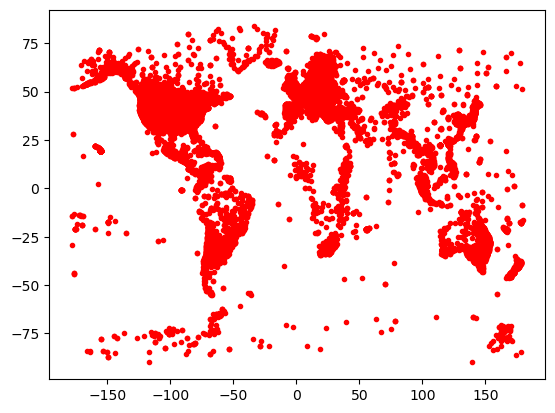

In [10]:
lat = myConnection.getColumn('solidearth', 'gps_station', 'reflat')
lon = myConnection.getColumn('solidearth', 'gps_station', 'reflon')
plt.plot(lon, lat, 'r.')

## Get Station and Site Information Tables

This section demonstrates how to return tables, with some basic filtering examples. The filtering is fairly basic, but since tables are return as pandas data frames, additional filtering can be applied via pandas operations. Return the table with all of the top-level station data (e.g,, name, id, position, etc).

In [20]:
table = myConnection.getTableListing(schemaName='solidearth', tableName='gps_station')
table

SELECT * FROM solidearth.gps_station ;


,station_id,site_id,station_name,reflat,reflon,east_0,north_0,up_0,refframe,refheight,station_geom
0,4290,NaN,01NA,-12.478,130.982,-1951.0,-1379987.0,105.0,None,105.409,0101000020E61000008195438B6C5F6040DBF97E6ABCF4...
1,10605,NaN,02NA,-12.356,130.882,-1987.0,-1366458.0,117.0,None,117.652,0101000020E61000004E621058395C604083C0CAA145B6...
2,8173,NaN,0ABI,68.354,18.816,677.0,7585405.0,431.0,None,431.388,0101000020E610000037894160E5D032402DB29DEFA716...
3,9822,NaN,0ABN,65.034,21.333,1548.0,7215094.0,52.0,None,52.762,0101000020E61000006891ED7C3F5535401904560E2D42...
4,9848,NaN,0ABY,58.659,16.180,-1181.0,6504674.0,60.0,None,60.548,0101000020E6100000AE47E17A142E30403108AC1C5A54...
...,...,...,...,...,...,...,...,...,...,...,...
22038,4169,NaN,ZWO2,52.503,6.093,-450.0,5819290.0,65.0,None,65.610,0101000020E6100000AC1C5A643B5F1840AAF1D24D6240...
22039,22005,NaN,ZWOL,52.502,6.096,-301.0,5819243.0,86.0,None,86.657,0101000020E6100000FCA9F1D24D621840C74B37894140...
22040,8624,NaN,ZYRA,52.055,20.420,1391.0,5769437.0,157.0,None,157.400,0101000020E6100000EC51B81E856B3440D7A3703D0A07...
22041,21765,NaN,ZYWE,49.688,19.197,-190.0,5506161.0,405.0,None,405.901,0101000020E6100000DF4F8D976E323340F2D24D6210D8...


The site data table is retrieved as:

In [21]:
myConnection.getTableListing(schemaName='solidearth', tableName='site')

SELECT * FROM solidearth.site ;


,site_id,site_name,date_from,date_to,seasonal,bbox_latmin,bbox_latmax,bbox_lonmin,bbox_lonmax,site_location,category,area_sqkm,climate,characteristics,cGPS,koppen_index
0,5,Central Valley CA,2001-01-01,2030-12-31,True,34.9,36.9,-120.8,-119.0,0106000020E61000000100000001030000000100000005...,"Desert, Scrub, Savanna",35900,"Hot Mediterranean, Cold Desert","agriculture, high soil moisture variability, n...",135,"Csa, BWk"
1,6,Los Angeles Basin,2001-01-01,2023-12-31,True,33.4,34.5,-119.0,-117.4,0106000020E61000000100000001030000000100000005...,"Desert, Scrub, Savanna",17900,"Hot Mediterranean, Hot Steppe","urban, range of relief and decorrelation sourc...",177,"Csa, BSh"
2,7,Mojave Desert,2001-01-01,2023-12-31,True,34.5,35.7,-116.5,-114.2,0106000020E61000000100000001030000000100000005...,"Desert, Scrub, Savanna",27800,Hot desert,"arid, moderate relief, little transient deform...",38,BWh
3,8,Long Valley Caldera,2001-01-01,2023-12-31,True,37.1,38.2,-119.5,-118.1,0106000020E61000000100000001030000000100000005...,"Desert, Scrub, Savanna",15000,"Cold Steppe, Warm Mediterranean","variable relief, snow, land cover, tectonics a...",63,"BSk, Csb"
4,9,Mejillones Chile,2001-01-01,2023-12-31,True,-24.0,-22.0,-70.7,-67.0,0106000020E61000000100000001030000000100000005...,"Desert, Scrub, Savanna",84200,Cold Desert,"hyper-arid, ionosphere, large relief, change i...",21,BWk
5,10,Western Oregon,2001-01-01,2023-12-31,True,43.5,45.5,-124.4,-121.5,0106000020E61000000100000001030000000100000005...,Mixed Forest\n\n,51200,Warm Mediterranean,"big trees, forests, winter rainfall",92,Csb
6,11,Hokkaido Japan,2001-01-01,2023-12-31,True,41.8,44.4,139.8,143.3,0106000020E61000000100000001030000000100000005...,Mixed Forest\n\n,82000,Humid Continental,"snowfall, forests, tectonics, agriculture",106,Dfb
7,12,Houston Galveston,2001-01-01,2023-12-31,True,28.5,31.0,-97.3,-93.5,0106000020E61000000100000001030000000100000005...,Mixed Forest\n\n,102100,Humid Subtropical,"continental climate, subsidence, variable land...",183,Cfa
8,13,Big Island Hawaii,2001-01-01,2023-12-31,True,18.9,20.3,-156.2,-154.7,0106000020E61000000100000001030000000100000005...,Maritime\n,24400,"Rainforest, Temperate Oceanic","active lava flows, variable relief, tropical c...",99,"Af, Cfb"
9,14,North Island New Zealand,2001-01-01,2023-12-31,True,-40.6,-37.0,173.6,176.2,0106000020E61000000100000001030000000100000005...,Maritime\n,90500,Temperate Oceanic,"tectonics and volcanos, maritime, southern lat...",58,Cfb


To filter the sites for matches to a column(s), call with filters dict. In this example, the `%Humid%` indicates a wild card, so any value from the **climate** colum with the substring `Humid` will be selected.

In [22]:
myConnection.getTableListing(schemaName='solidearth', tableName='site', filters={'climate': '%Humid%'})

climate
SELECT * FROM solidearth.site  WHERE climate LIKE %(climate)s;


,site_id,site_name,date_from,date_to,seasonal,bbox_latmin,bbox_latmax,bbox_lonmin,bbox_lonmax,site_location,category,area_sqkm,climate,characteristics,cGPS,koppen_index
0,11,Hokkaido Japan,2001-01-01,2023-12-31,True,41.8,44.4,139.8,143.3,0106000020E61000000100000001030000000100000005...,Mixed Forest\n\n,82000,Humid Continental,"snowfall, forests, tectonics, agriculture",106,Dfb
1,12,Houston Galveston,2001-01-01,2023-12-31,True,28.5,31.0,-97.3,-93.5,0106000020E61000000100000001030000000100000005...,Mixed Forest\n\n,102100,Humid Subtropical,"continental climate, subsidence, variable land...",183,Cfa


Similarly, to select sites with **category** `Desert` and **climate** `hot`, the query would be:

In [23]:
myConnection.getTableListing(schemaName='solidearth', tableName='site', filters={'category': '%Desert%', 'climate': '%Hot%'})

category
climate
SELECT * FROM solidearth.site  WHERE category LIKE %(category)s AND climate LIKE %(climate)s;


,site_id,site_name,date_from,date_to,seasonal,bbox_latmin,bbox_latmax,bbox_lonmin,bbox_lonmax,site_location,category,area_sqkm,climate,characteristics,cGPS,koppen_index
0,5,Central Valley CA,2001-01-01,2030-12-31,True,34.9,36.9,-120.8,-119.0,0106000020E61000000100000001030000000100000005...,"Desert, Scrub, Savanna",35900,"Hot Mediterranean, Cold Desert","agriculture, high soil moisture variability, n...",135,"Csa, BWk"
1,6,Los Angeles Basin,2001-01-01,2023-12-31,True,33.4,34.5,-119.0,-117.4,0106000020E61000000100000001030000000100000005...,"Desert, Scrub, Savanna",17900,"Hot Mediterranean, Hot Steppe","urban, range of relief and decorrelation sourc...",177,"Csa, BSh"
2,7,Mojave Desert,2001-01-01,2023-12-31,True,34.5,35.7,-116.5,-114.2,0106000020E61000000100000001030000000100000005...,"Desert, Scrub, Savanna",27800,Hot desert,"arid, moderate relief, little transient deform...",38,BWh


In [24]:
myConnection.getTableListing(schemaName='solidearth', tableName='interferogram')

SELECT * FROM solidearth.interferogram ;


,interferogram_id,site_id,track_frame_id,obs_mode,polarization,bandwidth_pri,bandwidth_sec,product_type,product_path,creator,...,repeat_date,isce_version,producer,config_file_path,date_created,granule_name,cycles_apart,band,input_type,archived
0,1,None,L001_F001_AF,None,HH,20,20,GUNW,test,user1,...,2024-01-01 00:00:00+00:00,0.18,custom,test,2024-06-01 00:00:00+00:00,test,10,L,ALOS,ready


## Station Name to ID

Determine the station ID (e.g., 16156) from the station name (e.g., LIZY). This translation is needed to map the station name to station id needed to index the table above.

In [25]:
myConnection.stationNameToID('LIZY', schemaName='solidearth')

16516

## Get GPS Data for Date Range

Return all the data for a designated station for the decimal date range (d1, d2). This next cell could take a minute or more to query the DB. 

In [28]:
%%time
d1 = 2019
d2 = 2024
myData = myConnection.getStationDateRangeData('LIZY', d1, d2, 'solidearth', 'gps_measurement')
myData

CPU times: user 7.62 ms, sys: 350 µs, total: 7.97 ms
Wall time: 1min 15s


,measurement_id,station_id,gps_version_id,measurement_dt,decimal_year,east,north,up,ant,sig_e,sig_n,sig_u,corr_en,corr_eu,corr_nu
0,32426694,16516,1,2019-01-01,2019.0007,0.268310,1.041053,0.163901,0.0,0.000729,0.001010,0.003054,0.027100,-0.007433,0.008353
1,32426695,16516,1,2019-01-02,2019.0034,0.268359,1.039897,0.161507,0.0,0.000752,0.001039,0.003136,0.001439,0.011485,0.012033
2,32426696,16516,1,2019-01-03,2019.0062,0.269582,1.040483,0.159832,0.0,0.000819,0.001158,0.003330,0.006994,0.026640,-0.002563
3,32426697,16516,1,2019-01-04,2019.0089,0.269202,1.040916,0.163606,0.0,0.000719,0.000996,0.002984,0.031598,0.002110,-0.017285
4,32426698,16516,1,2019-01-05,2019.0116,0.268687,1.040904,0.166563,0.0,0.000711,0.000975,0.002922,0.020957,0.006565,-0.042176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,32427731,16516,1,2021-11-13,2021.8672,0.321475,1.085974,0.166923,0.0,0.000991,0.001413,0.004178,0.007887,-0.063174,-0.130998
1038,32427732,16516,1,2021-11-14,2021.8700,0.321555,1.085070,0.174551,0.0,0.001123,0.001541,0.004437,-0.040131,-0.031423,-0.038598
1039,32427733,16516,1,2021-11-15,2021.8727,0.320230,1.085936,0.166855,0.0,0.001009,0.001509,0.004114,-0.059304,0.045762,-0.008213
1040,32427734,16516,1,2021-11-16,2021.8754,0.320142,1.087823,0.169328,0.0,0.000974,0.001294,0.003786,0.070651,-0.017929,-0.089931


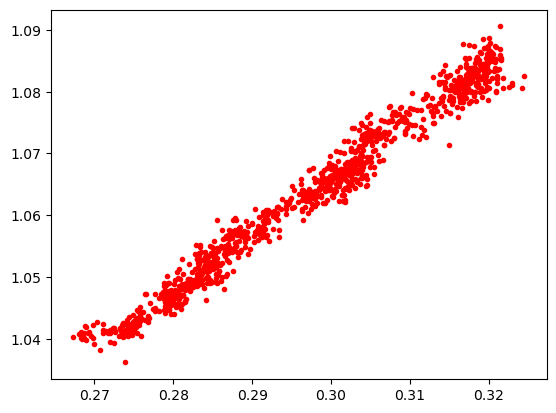

In [27]:
plt.plot(myData['east'], myData['north'], 'r.')

## Rollback a Query Error

This will reset the connection after a query fails with an error. Most of the routines should trap errors and automatically rollback.

In [27]:
myConnection.connection.rollback()

## Close the connection

Close the connection when finished.

In [28]:
myConnection.close()